In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (700000, 26)
Test shape: (300000, 25)


In [3]:
train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
test.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


## Basic Exploratory Data Analysis 

In [5]:
TARGET = "diagnosed_diabetes"
ID_COL = "id"

train.info()

assert TARGET in train.columns, f"Target column '{TARGET}' not found in train!"
assert ID_COL in train.columns, f"ID column '{ID_COL}' not found!"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

diagnosed_diabetes
1.0    436307
0.0    263693
Name: count, dtype: int64
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


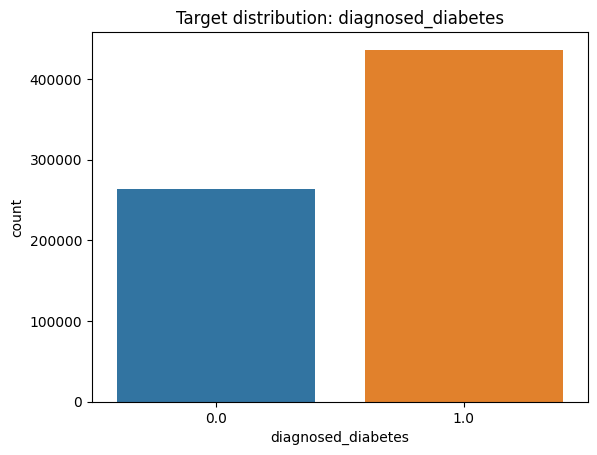

In [6]:
# Examine distribution

# Counts
print(train[TARGET].value_counts())

# Proportions
print(train[TARGET].value_counts(normalize=True))

# Simple barplot
sns.countplot(x=TARGET, data=train)
plt.title("Target distribution: diagnosed_diabetes")
plt.show()


In [7]:
# Examine missing values

# Missing count per column
missing_counts = train.isnull().sum().sort_values(ascending=False)
missing_pct    = (train.isnull().mean() * 100).sort_values(ascending=False)

print("Top 20 columns by missing count:")
print(missing_counts.head(20))

print("\nTop 20 columns by missing percent:")
print(missing_pct.head(20))


Top 20 columns by missing count:
id                         0
age                        0
cardiovascular_history     0
hypertension_history       0
family_history_diabetes    0
employment_status          0
smoking_status             0
income_level               0
education_level            0
ethnicity                  0
gender                     0
triglycerides              0
ldl_cholesterol            0
hdl_cholesterol            0
cholesterol_total          0
heart_rate                 0
diastolic_bp               0
systolic_bp                0
waist_to_hip_ratio         0
bmi                        0
dtype: int64

Top 20 columns by missing percent:
id                         0.0
age                        0.0
cardiovascular_history     0.0
hypertension_history       0.0
family_history_diabetes    0.0
employment_status          0.0
smoking_status             0.0
income_level               0.0
education_level            0.0
ethnicity                  0.0
gender                     0

In [8]:
# separate features (X) and target (y)

X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

X_test_raw = test.drop(columns=[ID_COL])
test_ids   = test[ID_COL].copy()


In [9]:
#identify numeric and categorical variables

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))
print("\nFirst few numeric:", numeric_features[:10])
print("First few categorical:", categorical_features[:10])


Numeric features: 18
Categorical features: 6

First few numeric: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp']
First few categorical: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


### Examine numeric features

In [10]:
train[numeric_features].describe().T.head(20)


,count,mean,std,min,25%,50%,75%,max
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00
diastolic_bp,700000.0,75.440924,6.825775,51.00,71.00,75.00,80.00,104.00


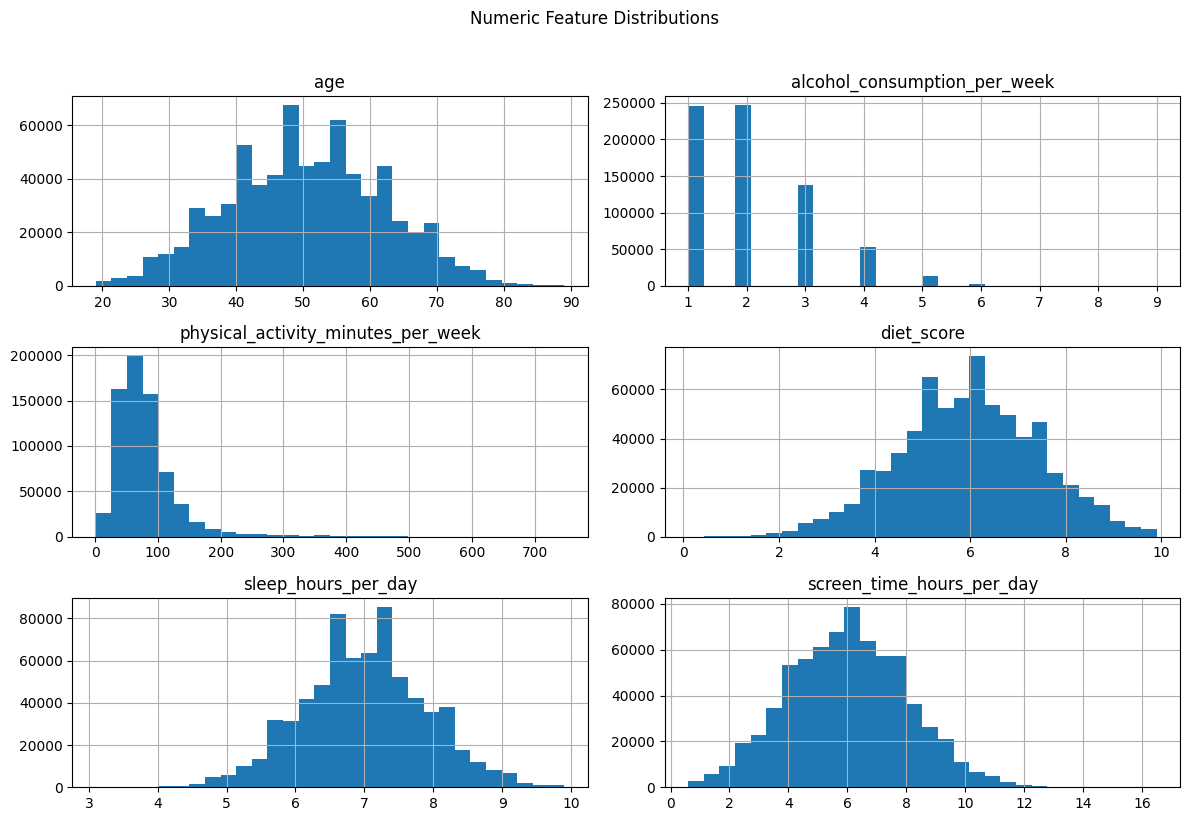

In [11]:
# histogram of numeric features

sample_num_feats = numeric_features[:6]  # or manually pick important ones

train[sample_num_feats].hist(figsize=(12, 8), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


In [12]:
features_to_plot = []

# Example: if these exist in your dataset
for col in ["age", "bmi", "glucose_fasting", "hba1c"]:
    if col in numeric_features:
        features_to_plot.append(col)

print("Numeric features to compare vs target:", features_to_plot)


Numeric features to compare vs target: ['age', 'bmi']


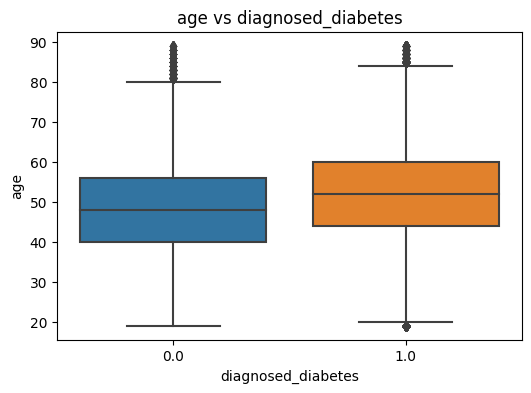

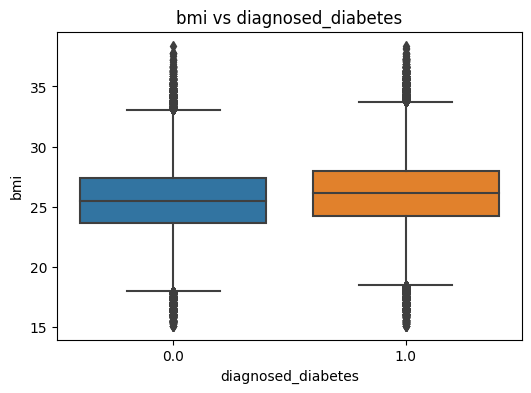

In [13]:
# bloxplots

for col in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=TARGET, y=col, data=train)
    plt.title(f"{col} vs {TARGET}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


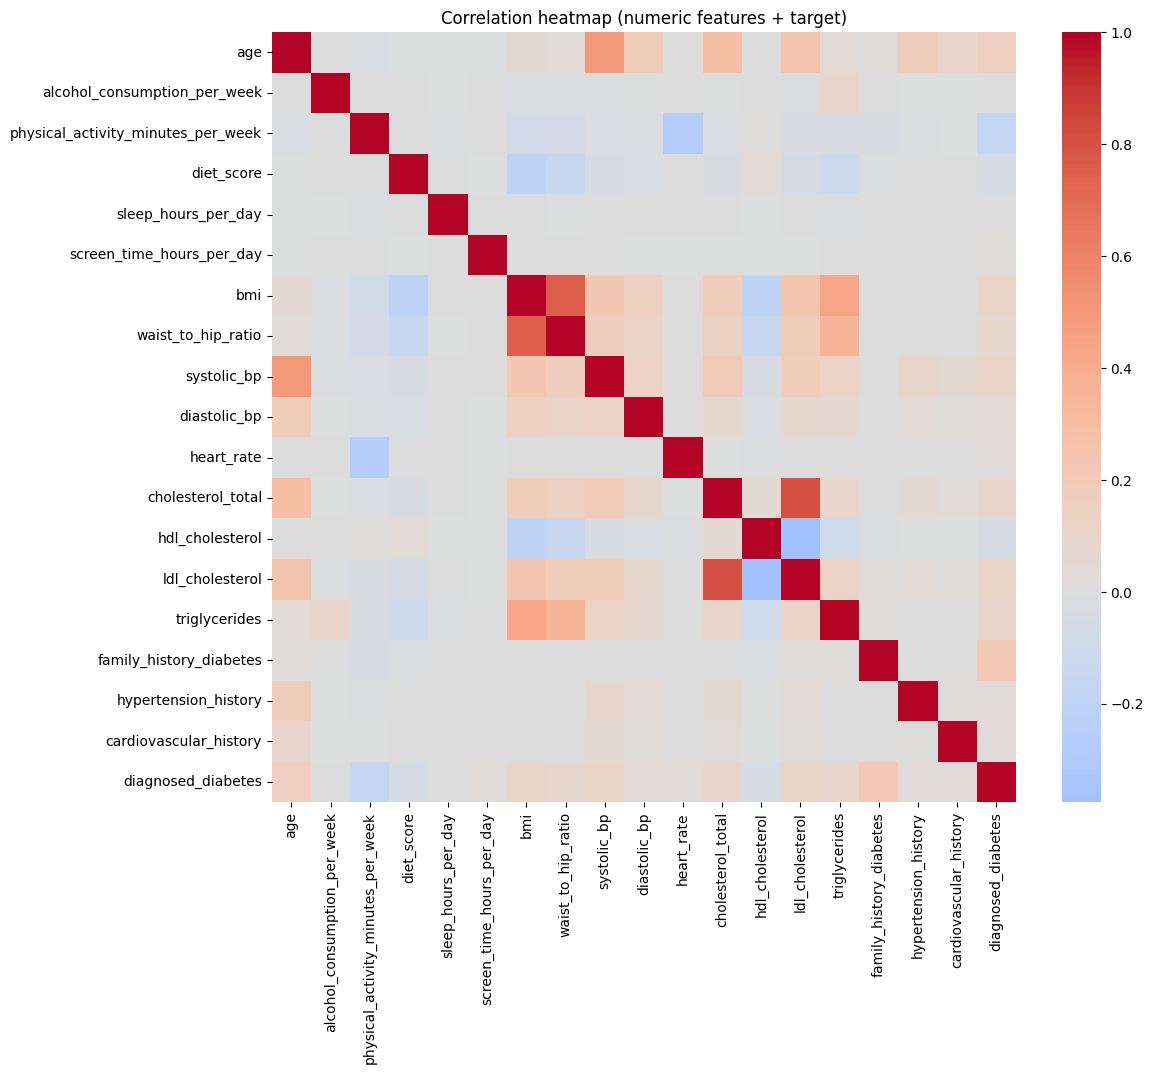

In [14]:
# Correlation heatmap

corr_df = train[numeric_features + [TARGET]]
corr = corr_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features + target)")
plt.show()


In [15]:
#Relationship with the Target variable

corr_with_target = corr[TARGET].sort_values(ascending=False)
print("Correlation with diagnosed_diabetes:")
print(corr_with_target)


Correlation with diagnosed_diabetes:
diagnosed_diabetes                    1.000000
family_history_diabetes               0.211064
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
diastolic_bp                          0.036271
hypertension_history                  0.029979
cardiovascular_history                0.024746
heart_rate                            0.023865
screen_time_hours_per_day             0.018213
sleep_hours_per_day                   0.003509
alcohol_consumption_per_week          0.002991
diet_score                           -0.050119
hdl_cholesterol                      -0.053231
physical_activity_minutes_per_week   -0.169789
Name: diagnosed_diabetes, dtype: float64


## Categorical Features

In [16]:
for col in categorical_features[:10]:  # just first 10 to avoid spam
    print(f"\nColumn: {col}")
    print(train[col].value_counts(dropna=False).head())



Column: gender
gender
Female    363237
Male      333085
Other       3678
Name: count, dtype: int64

Column: ethnicity
ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64

Column: education_level
education_level
Highschool      344145
Graduate        261268
Postgraduate     79642
No formal        14945
Name: count, dtype: int64

Column: income_level
income_level
Middle          290557
Lower-Middle    178570
Upper-Middle    127836
Low              85803
High             17234
Name: count, dtype: int64

Column: smoking_status
smoking_status
Never      494448
Current    103363
Former     102189
Name: count, dtype: int64

Column: employment_status
employment_status
Employed      516170
Retired       115735
Unemployed     49787
Student        18308
Name: count, dtype: int64


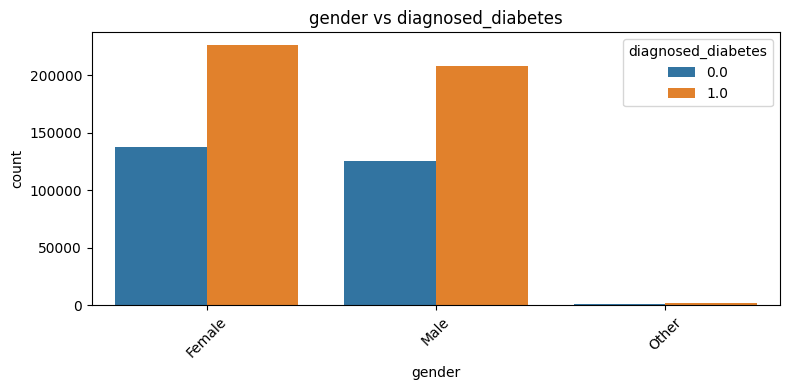

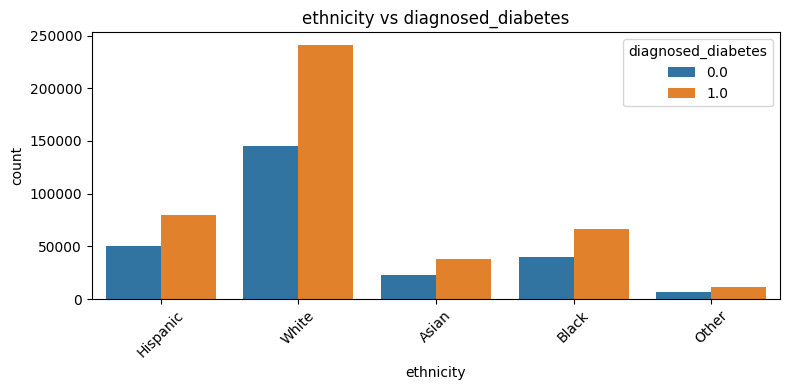

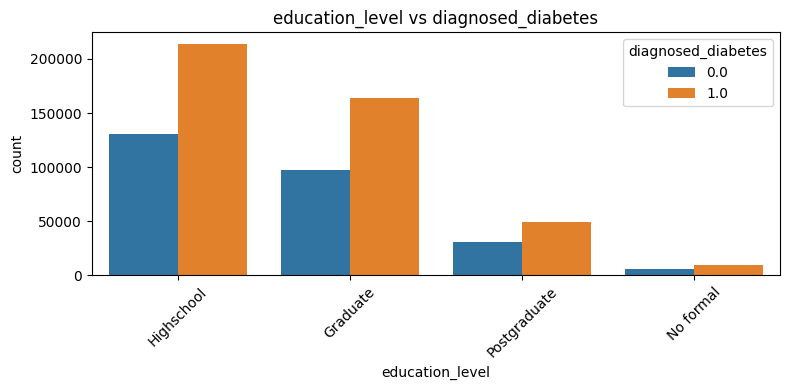

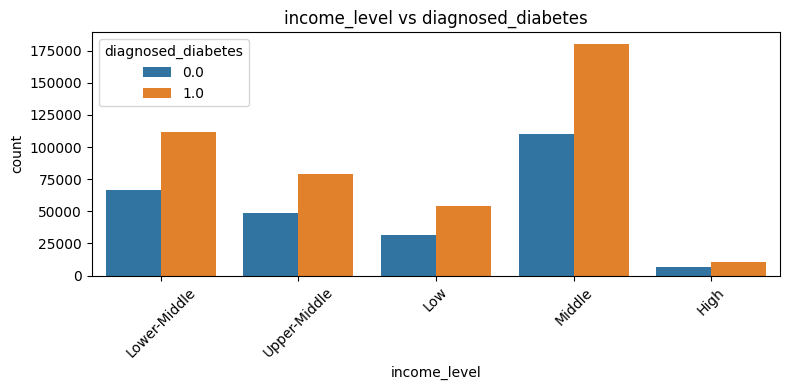

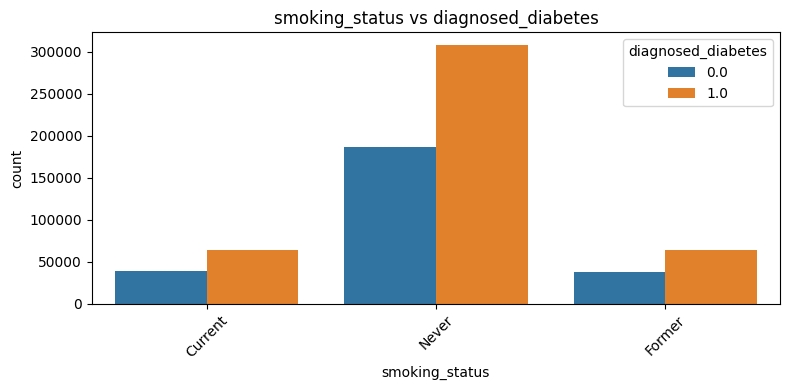

In [17]:
for col in categorical_features[:5]:
    if train[col].nunique() <= 10:  # avoid huge charts
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, hue=TARGET, data=train)
        plt.title(f"{col} vs {TARGET}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


## Build preprocessing pipeline - ensure data ready for modeling

In [18]:
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## Model for Analysis

In [19]:
TARGET = "diagnosed_diabetes"
ID_COL = "id"

X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

X_test_raw = test.drop(columns=[ID_COL])
test_ids = test[ID_COL].copy()


In [20]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical features:", categorical_features)


Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [22]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Ensure these are set correctly already:
# X = train.drop(columns=[TARGET, ID_COL])
# y = train[TARGET]
# X_test_raw = test.drop(columns=[ID_COL])

for col in categorical_features:
    X[col] = X[col].astype("category")
    X_test_raw[col] = X_test_raw[col].astype("category")



In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_lgb = np.zeros(len(X))
test_preds_lgb = np.zeros(len(X_test_raw))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== LightGBM Fold {fold+1} =====")
    
    X_train_f, X_valid_f = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_f, y_valid_f = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_lgb = lgb.LGBMClassifier(
        objective="binary",
        metric="auc",
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,           # no limit, controlled by num_leaves
        min_child_samples=40,   # regularization
        subsample=0.8,          # row sampling (bagging_fraction)
        colsample_bytree=0.8,   # feature_fraction
        n_jobs=-1,
        random_state=42
    )
    
    model_lgb.fit(
        X_train_f, y_train_f,
        eval_set=[(X_valid_f, y_valid_f)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(100)
        ]
    )
    
    valid_pred = model_lgb.predict_proba(X_valid_f)[:, 1]
    oof_preds_lgb[valid_idx] = valid_pred
    
    # accumulate test predictions
    test_preds_lgb += model_lgb.predict_proba(X_test_raw)[:, 1] / kf.n_splits

# CV score
oof_auc_lgb = roc_auc_score(y, oof_preds_lgb)
print("\nOverall LightGBM CV ROC-AUC:", oof_auc_lgb)



===== LightGBM Fold 1 =====
[LightGBM] [Info] Number of positive: 349045, number of negative: 210955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623295 -> initscore=0.503556
[LightGBM] [Info] Start training from score 0.503556
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.718661
[200]	valid_0's auc: 0.723543
[300]	valid_0's auc: 0.725051
[400]	valid_0's auc: 0.725912
[500]	valid_0's auc: 0.726628
[600]	valid_0's auc: 0.726992
[700]	valid_0's auc: 0.727249
[800]	valid_0's auc: 0.72732
[900]	valid_0's auc: 0.727355
[1000]	valid_0's auc: 0.727551
Did not meet early stopping. Best iteration is:
[9

## Prepare submission

In [25]:
submission_lgb = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: test_preds_lgb
})

submission_lgb.to_csv("submission_lightgbm_kfold.csv", index=False)
print("Saved submission_lightgbm_kfold.csv")
submission_lgb.head()


Saved submission_lightgbm_kfold.csv


,id,diagnosed_diabetes
0,700000,0.506147
1,700001,0.685322
2,700002,0.784495
3,700003,0.388033
4,700004,0.913860
